# Graphs from xyz Data
*Applying Networkx*

---

In [1]:
# What Python version are we using? What OS are we on?
import sys
print(sys.version)

3.6.6 |Anaconda, Inc.| (default, Jun 28 2018, 17:14:51) 
[GCC 7.2.0]


In [2]:
# Import basic Python tools.
import itertools
import collections
import random
import functools

# Import data science packages.
import numpy as np
import networkx as nx

# Import plotting tools.
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go

# Setup matplotlib for nice notebook output.
%matplotlib inline

# Enable plotly notebook mode.
init_notebook_mode()

## Creating a Graph from an XYZ File

*As gone over in the previous lesson. Some minor changes.*

---

In [3]:
ELEMENT_COLORS = {
    'H': 'red',
    'O': 'blue',
}

ELEMENT_SIZES = {
    'H': 25,
    'O': 60,
}

#### Any python object can be a node and you can assign attributes to the note.

In [4]:
def create_graph_from_xyz(xyz_filepath):
    """Creates a new networkx graph object from the given file.
    
    :param xyz_filepath:
        The filepath, as a string, from which the network will
        be constructed.
    
    :returns:
        A networkx graph object.
    """
    
    # Open the file and read the lines therein.
    with open(xyz_filepath) as in_file:
        
        # Drop the first two lines of the .xyz file.  
        data = in_file.readlines()[2:]
        
    # Create the empty network to be returned.
    graph = nx.Graph()
    
    # Iterate through the data, and generate a node for each line.
    for index, line in enumerate(data):
        
        # Split the string by whitespace.
        line = line.split()
        
        # Get the element type.
        node_element = line[0]
        
        # Get the x, y, z coordinates.
        x_val = np.float(line[1])
        y_val = np.float(line[2])
        z_val = np.float(line[3])
        
        # Create the node within the new graph.
        graph.add_node(
            # Save nodes by index.
            node_for_adding=index,
            
            # Remaining arguments passed here will be passed to
            # the node as key: value pair attributes.
            element=node_element,
            x=x_val,
            y=y_val,
            z=z_val,
            size=ELEMENT_SIZES[node_element],
            color=ELEMENT_COLORS[node_element]
        )
        
    # Return the graph generated.
    return graph

## Calculating a Distance Matrix

*I will supply some heavily commented functions. This lesson is more about how we use graph theory, so we will not focus on them.*

---

### Preparing some Helper Functions

In [5]:
def get_node_xyz(in_node, graph):
    """Returns a tuple of x, y, z values from a given
    graph and node pair. These attributes must already be
    defined in the node.
    
    :param in_node:
        A networkx node object contained within the graph
        input above.
    
    :param graph:
        A networkx graph object.
        
    :returns:
        A tuple of the x, y, z coordinates of the node.
    """
    # Find the coordinates.
    xx = graph.node('x')[in_node]
    yy = graph.node('y')[in_node]
    zz = graph.node('z')[in_node]
    
    # Return the tuple of them.
    return np.array((xx, yy, zz))

In [6]:
def periodic_dist_vector(psa, psb, pL):
    """Calculate the distance vectors between two sets of points under
    periodic conditions.
    
    :param psa:
        An array of coordinate vectors.

    :param psb:
        An array of coordinate vectors.
    
    :param pL:
        The period length.
    """
    
    diff_arrays = psa[..., None] - psb.T[None, ...]
    diff_arrays = np.moveaxis(diff_arrays, -1, 0)# a way of handling the repeating structure 
    return np.remainder(diff_arrays + pL / 2.0, pL) - pL / 2.0

In [7]:
def euclidean_dist(dist_vector_array):
    """Calculate the euclidean distance of the input array along the last axis.
    """
    return np.linalg.norm(dist_vector_array, axis=-1)

In [8]:
def periodic_calculate_distance_matrix(in_graph):
    """Calculate and return a distance matrix based a given graph.
    
    :param in_graph:
        A networkx graph object. The nodes in this graph must have
        x, y, and z attributes for this function to work.
        
    :returns:
        A distance matrix as a numpy array.
    """
    
    # Find the length / number of atoms in the system.
    atoms_total = len(in_graph)

    # Create a matrix of zeros the size of our edges.
    distance_matrix = np.zeros((atoms_total, atoms_total))
    
    # Get the x, y, z coordinates from the graph nodes.
    xyz_vals = np.array([get_node_xyz(n, in_graph) for n in in_graph])
    
    # Get the maximum and minumum for the period length.
    max_coords = np.amax(xyz_vals, axis=0)
    min_coords = np.amin(xyz_vals, axis=0)
    
    # Calculate the size of the box.
    period_size = max_coords - min_coords#Bounds the box to consider

    # Calculate the periodic distance vectors.
    periodic_dist_vectors = periodic_dist_vector(xyz_vals, xyz_vals, period_size)
    
    # Calculate the euclidean distances of these vectors.
    e_distances = euclidean_dist(periodic_dist_vectors)
    
    return (periodic_dist_vectors, e_distances)

## Calculate and Check the Matrix

*The visualization here isn't useful beyond a quick check of our functions.*

In [9]:
# Create a graph from our xyz file.
XYZ_GRAPH = create_graph_from_xyz('data/realwater.xyz')

# Test our distance array function!
XYZ_GRAPH_vectors, XYZ_GRAPH_vectors_e_distances = periodic_calculate_distance_matrix(XYZ_GRAPH)

In [10]:
def visualize_distance_matrix(matrix):
    """View a given distance matrix as an image.
    
    Usefull for identifying bad data, as artifacts can
    be seen.
    """

    # Create the figure and axis to plot on.
    fig, ax = plt.subplots(figsize=(10,8))
    
    # Draw the image.
    cax = ax.imshow(matrix)
    
    # Add a color bar.
    fig.colorbar(cax)
        
    # Show the plot.
    plt.show()

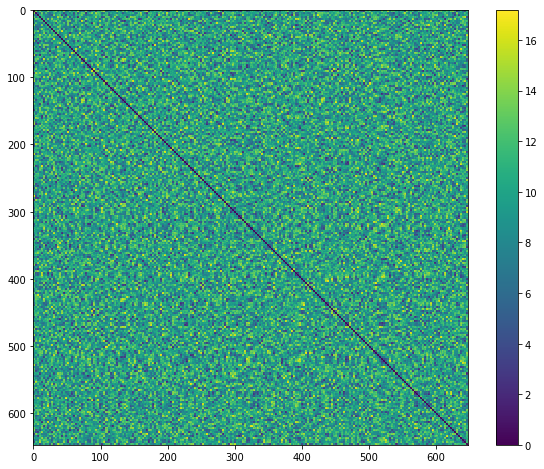

In [11]:
visualize_distance_matrix(XYZ_GRAPH_vectors_e_distances)

*Note that this matrix is redundant.*

### Relating to the Graph Indexes

*The data has its order integrity intact. So each line will correspond to the index of a node.*

In [12]:
oxygen_idxs = [n for n,v in XYZ_GRAPH.nodes(data=True) if v['element'] == 'O']
hydrogen_idxs = [n for n,v in XYZ_GRAPH.nodes(data=True) if v['element'] == 'H']

In [13]:
def add_distance_array_to_nodes(graph):
    """Stores a 1D array of distances to other atoms on the
    corresponding node within graph. The distance matrix
    creation function will be called by this function.
    
    The graph and distance_matrix objects must be indexed
    the same.
    
    :param graph:
        A networkx graph object. Node labels should be indexes.
    
    :returns:
        Modified the graph in place. Appends distance arrays
        to each node.
    """
    
    # Calculate the distance matrix for the given graph.
    dist_vectors, e_dists = periodic_calculate_distance_matrix(graph)
    
    # Iterate through the graph nodes and each array within
    # the newly calculated distance matrix.
    for nd, dv, ed in zip(list(graph), dist_vectors, e_dists):
        
        # Add the distance array attribute to the node.
        graph.add_node(nd, distance_array=ed, distance_vectors=dv)

In [14]:
add_distance_array_to_nodes(XYZ_GRAPH)

## Calculating the Pair-wise Radial Distribution

First a helper function, and a note on solving generic problems in Python (and other languages).

The [answer](https://docs.python.org/3/library/itertools.html).

---

In [15]:
def get_box_size(in_graph):    
    # Get the x, y, z coordinates from the graph nodes.
    xyz_vals = np.array([get_node_xyz(n, in_graph) for n in in_graph])
    
    # Get the maximum and minumum for the period length.
    max_coords = np.amax(xyz_vals, axis=0)
    min_coords = np.amin(xyz_vals, axis=0)
    
    # Calculate the size of the box.
    period_size = max_coords - min_coords
    
    return period_size

In [16]:
def pairwise(iterable):
    '''
    s -> (s0,s1), (s1,s2), (s2, s3), ...
    '''
    a, b = itertools.tee(iterable)
    next(b, None)
    return zip(a, b)

In [17]:
def rdf(in_graph, bin_width=0.05, plot_range=(1.0, 5.0),from_element={'O'}, to_element={'H'}):
    """    
    """
    
    # Iterate over the nodes and create a list of nodes that have the matching element
    # given in `from_element`.
    from_nodes = [n for n, v in in_graph.nodes(data=True) if v['element'] in from_element]
    to_nodes = [n for n, v in in_graph.nodes(data=True) if v['element'] in to_element]
    
    # Get the distance arrays from the input graph.
    # First iterate over only the 'from_nodes', then take only the indicies in 'to_nodes'.
    distance_array = [np.trim_zeros(in_graph.node('distance_array')[n][to_nodes]) for n in from_nodes]
    
    # Calculate the box size.
    box_size = get_box_size(in_graph)
    
    # Get the largest possible vector?
    # Use that value for the maximum range of the bins.
    box_vector = np.linalg.norm(box_size)
    
    # Calculate the number density.
    number_density = len(distance_array) / box_vector
        
    # Create the bins for the histogram.
    # This models the slices / layers around the atom of interest.
    atom_bins = np.arange(*plot_range, bin_width)

    # Calculate the sphere cuts volume array.
    sphere_cut_ranges = np.array([pair for pair in pairwise(atom_bins)])
    sphere_volumes = 4.0 / 3.0 * np.pi * sphere_cut_ranges**3
    sphere_cut_volumes = sphere_volumes[..., 1] - sphere_volumes[..., 0]

    # Enumerate through the distance arrays, these indexes are the same as the atoms.
    # First create an zeroed numpy array to hold the values.
    # The -1 is due to the pair-wise usa above.
    bins_collected = np.zeros((len(in_graph), len(atom_bins) - 1))

    for atom, da in enumerate(distance_array):
        
        # Bin them by range increments.
        bin_counts, bin_edges = np.histogram(da, bins=atom_bins)
        
        # Assign them to the bins_collected array.
        bins_collected[atom] = bin_counts
    
    # Sum the extracted bin counts.
    summed_bins = np.sum(bins_collected, axis=0)
    
    # Normalize the sums by dividing by the volumes and number density.
    normalized_bins = summed_bins / sphere_cut_volumes / number_density
    
    XX = atom_bins[:-2]
    YY = normalized_bins[1:]

    # Create the trace for plotly.
    trace = go.Scatter(
        x = XX,
        y = YY,
        mode = 'markers',
        name='RDF')

    data = [trace]

    iplot(data)

In [18]:
rdf(XYZ_GRAPH)

In [19]:
rdf(XYZ_GRAPH, bin_width=0.05, plot_range=(1.0, 5.0),from_element={'O'}, to_element={'O'})

## Creating and Using Edges

*Edge Attributes / Weights*


---

### Conditional Edge Generation

The idea behind this function is to separate the logic of iterating through node pairs from the logic of examining nodes.

---

In [22]:
def add_conditional_edge(predicates, graph):
    """Iterates through each node within a graph, checks a
    boolean predicate (which can examine another, or all of
    the other nodes) and adds an edge if the predicates all
    return true for a given node pair.
    
    :param predicates:
        A list of boolean functions that examine a pair of nodes.

    :param graph:
        A network.x graph object.
    
    :param label:
        An optional label to be attached to this edge.

    """
    
    # Get the list of all nodes contained within the given graph.
    node_list = list(graph)

    # Generate all possible combinations of nodes of length 2.
    node_combinations = itertools.combinations(node_list, 2)
    
    # Iterate over all of the node combinations.
    for n1, n2 in node_combinations:
        
        # Check all of the predicates, pass the two nodes being
        # examined, also pass the graph so other attributes can
        # be viewed by the predicate functions.
        if all(p(n1, n2, graph) for p in predicates):
            
            # All predicates have returned True if the function
            # gets to this point. So add the new edge.
            graph.add_edge(n1, n2)

### Define Predicate Functions

In [23]:
def distance_check(node1, node2, graph, low, high):
    """Examines node1 and ndoe2 within a given graph.

    :param node1:
        Index value of the first node.
        
    :param node2:
        Index value of the second ndoe.
        
    :param graph:
        A networkx graph object that contains node1 and node2.
        
    :param low:
        The lowest acceptable distance, not inclusive.
        
    :param high:
        The highest acceptable distance, not inclusive.
        
    :returns:
        True or False, based on the distance between nodes.
    """
    
    # Get the distance array from the first node.
    node1_distance_array = graph.node('distance_array')[node1]

    # The distance between the two nodes can be looked up from
    # the distance_array by using the index of the second ndoe.
    n1_n2_dist = node1_distance_array[node2]
    
    # Now compare the distance to the given ranges.
    if low < n1_n2_dist < high:
        return True

In [24]:
def element_check(node1, node2, graph, element_set):
    """Examines the elements of node1 and node2 to see
    if they are equal to the set provided in element_set.
    
    :param node1:
        Index value of the first node.
        
    :param node2:
        Index value of the second ndoe.
        
    :param graph:
        A networkx graph object that contains node1 and node2.
        

    :param element_set:
        The set of elements we wish to compare to.

    :returns:
        True or False, based on the element type of the nodes.

    """
    
    # Get the element type from each node.
    node_1_element = graph.node('element')[node1]
    node_2_element = graph.node('element')[node2]
       
    # Build a set from the element types.
    node_set = set([node_1_element, node_2_element])#a set is like a list but with unique values
    
    
    # Compare a set of those elements to the given element_set.
    if node_set == element_set:
        return True

## Testing Predicate Functions

To easily use the above (and future) predicate functions they need to be supplied with appropriate default arguments. The Pythonic way to handle this is with the functools standard library.

This is done so we can define a distance function with a certain low and high value only once.

---

In [25]:
# Remake the graph.
XYZ_GRAPH = create_graph_from_xyz('data/realwater.xyz')

# Add the distance arrays to each node.
# This is done this way to make learning more intuitive, and
# the functions simpler. Consider how much more memory this
# method consumes.
add_distance_array_to_nodes(XYZ_GRAPH)

In [26]:
# Define a distance predicate function.
water_distance_check = functools.partial(distance_check, low=0.9, high=1.0)

# Call the edge adding function with our prepared predicate.
add_conditional_edge(predicates=[water_distance_check], graph=XYZ_GRAPH)

### Visualizing Graphs and Edges

The easiest way to check if these operations are doing anything close to what they are supposed to is to view the data.

---

In [27]:
def plot_degree_histogram(in_graph, element_set=set(['O', 'H'])):
    """Plot a degree histogram of a given in_grpah.
    """
    
    trace_list = list()
    # Iterate through the provided set to generate the trace.
    for element in element_set:
        
        degree_list = list()
        
        # Iterate through those atoms within the graph.
        for nd in in_graph.nodes():
            # We only care about nodes that are oxygen.
            if in_graph.node('element')[nd] == element:

                degree_list.append(in_graph.degree(nd))
            
        degree_list = np.array(degree_list)
        new_trace = go.Histogram(
            x=degree_list,
            name=element
        )
        trace_list.append(new_trace)
        
    layout = go.Layout(
        title='Edge Count Histogram',
        xaxis=dict(title='Edge Count'),
        yaxis=dict(title='Observed Count'))
    
    fig = go.Figure(data=trace_list, layout=layout)
    iplot(fig)

In [28]:
# Default widths are a little crazy, but whatever.
plot_degree_histogram(XYZ_GRAPH)

In [29]:
def draw_plotly_3d_scatter(in_graph):
    """Draws every edge on every node in the given graph. """
    # Get the coordinate attributes back out of the graph.
    x_vals, y_vals, z_vals = np.array([get_node_xyz(n, in_graph) for n in in_graph]).T

    # Create the color and size lists.
    c_vals = [x for x in nx.get_node_attributes(in_graph, 'color').values()]
    s_vals = [x for x in nx.get_node_attributes(in_graph, 'size').values()]
    
    # Add the points to a scatter plot.
    trace1 = go.Scatter3d(
        x=x_vals,
        y=y_vals,
        z=z_vals,
        mode='markers',
        hovertext = ['Node Index: {0}'.format(x) for x in in_graph.nodes()],
        marker=dict(
            sizemode='area',
            color=c_vals,
            size=s_vals,
            opacity=0.8))
    
    # Create empty list for line segments
    xs, ys, zs = [], [], []
    
    # Create an empty list for line lengths for hover information.
    line_lengths = []
    
    # Iterate through the edges, and draw line segments for each set.
    # For every node, get a list of neighbor nodes indicies
    # Use those indicies to look up their corresponding distance vector.
    # Sum the distance vector and the nodes original coordinates to draw
    # bonds that go outside the displayed box, thus showing how our edges
    # propogate through the periodic boundary conditions.
    for nd in in_graph.nodes():

        # Get a list of neighbor nodes indicies.        
        for nbr in in_graph[nd]:
            
            # Assign the x, y, z variables.    
            node_coords = get_node_xyz(nd, in_graph)
            
            # Add the corresponding distance vector.
            edge_vector = in_graph.node('distance_vectors')[nd][nbr]
            
            # Add these values to a corresponding list.
            # The third value is none, otherwise a plane would be drawn.
            xs += [node_coords[0], edge_vector[0] + node_coords[0], None]
            ys += [node_coords[1], edge_vector[1] + node_coords[1], None]
            zs += [node_coords[2], edge_vector[2] + node_coords[2], None]
            
            # Get the lines length.
            line_lengths.append(in_graph.node('distance_array')[nd][nbr])
            
    # Add the node edges / line segments to the plot.
    trace2 = go.Scatter3d(
        x=xs,
        y=ys,
        z=zs,
        mode='lines',
        line=go.Line(color='grey', width=1),
#         hovertext=['Bond Length: {x:{5}.{5}}' for x in line_lengths]
    )

    # Show the plot.
    data = [trace1, trace2]
    fig = go.Figure(data=data)
    iplot(fig)

In [30]:
draw_plotly_3d_scatter(XYZ_GRAPH)

/home/tyler/anaconda3/envs/py36/lib/python3.6/site-packages/plotly/graph_objs/_deprecations.py:372: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




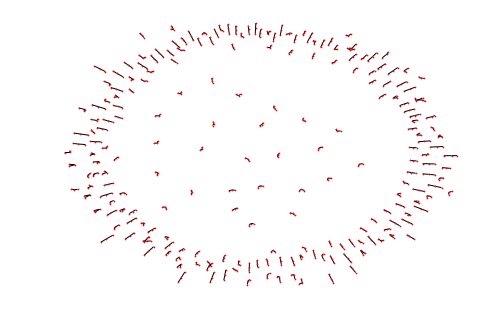

In [31]:
# We can even use a networkx draw call.
# Although nothing amazing pops out here.
nx.draw(XYZ_GRAPH, node_size=0.5)

# Everything again - Chemistry in Mind

---

In [30]:
# Create a new instance of TEST_GRAPH
WATER_HYDROGEN_BONDS = create_graph_from_xyz('data/realwater.xyz')

# Calculate the distance arrays and add them to the graph.
add_distance_array_to_nodes(WATER_HYDROGEN_BONDS)

# Create the predicate functions for water.
water_distance_check = functools.partial(distance_check, low=0.1, high=1.0)
O_H_check = functools.partial(element_check, element_set=set(['O', 'H']))

# Apply the predicates to create edges.
add_conditional_edge(predicates=[water_distance_check, O_H_check], graph=WATER_HYDROGEN_BONDS)

# Create predicate functions for hydrogen bonds.
h_bond_check = functools.partial(distance_check, low=1.6, high=2.6)

add_conditional_edge(predicates=[h_bond_check, O_H_check], graph=WATER_HYDROGEN_BONDS)

# View the graph.
draw_plotly_3d_scatter(WATER_HYDROGEN_BONDS)

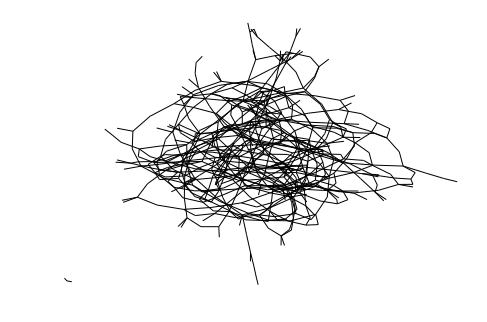

In [31]:
# Unfortunate default output.
nx.draw(WATER_HYDROGEN_BONDS, node_size=0)

### Adding Weights to our Edges

Really this is just another attribute.

---

In [32]:
def add_edge_weight(weighting_functions, graph, label=None):
    
    edge_list = nx.edges(graph)
    
    # Go through each edge.
    for curr_edge in edge_list:
                
        edge_attrs  = dict()
        
        # For each function given to analyze the edge.
        for wt_func in weighting_functions:
            
            # Apply the function.
            func_dict = wt_func(curr_edge, graph)
            # All of these functions should return a dictionary.

            # Merge these dictionaries, and pass them to the edge.
            # Some nifty python3.5+ short hand.
            # https://stackoverflow.com/a/26853961
            edge_attrs = {**edge_attrs, **func_dict}
        
        n1, n2 = curr_edge

        graph.add_edge(n1, n2, **edge_attrs)

In [33]:
def add_distance_weight_to_edge(in_edge, graph):
    
    n1, n2 = in_edge

    # Get the distance array from the first node.
    node1_distance_array = graph.node('distance_array')[n1]

    # The distance between the two nodes can be looked up from
    # the distance_array by using the index of the second ndoe.
    n1_n2_dist = node1_distance_array[n2]
    
    return {'distance': n1_n2_dist}

## Shortest Path

[Floyd–Warshall algorithm](https://en.wikipedia.org/wiki/Floyd%E2%80%93Warshall_algorithm) finds the shortest path between two nodes. This algoirthm is sensitive to the 'weight' of an edge.

---

In [34]:
add_edge_weight([add_distance_weight_to_edge], WATER_HYDROGEN_BONDS)

## Using Algorithms in Networkx

---

In [35]:
# This takes a long time!
# whp_fw = nx.floyd_warshall(WATER_HYDROGEN_BONDS, weight='distance')

In [36]:
def plot_fw_hist(in_graph, fw_dict, element_set=set(['O', 'H'])):
    """Plot a degree histogram of a given in_grpah.
    
    """
    
    trace_list = list()
    # Iterate through the provided set to generate the trace.
    for element in element_set:
        
        path_list = list()
        
        for node_idx, dist_list in fw_dict.items():
            
            if in_graph.node('element')[node_idx] == element:
                
                path_list.extend([v for k, v in dist_list.items() if v <= 100])
                
        path_list = np.array(sorted(path_list, reverse=True))

        new_trace = go.Histogram(
            x=path_list,
            name=element
        )
        trace_list.append(new_trace)
        
    layout = go.Layout(
        title='Edge Count Histogram',
        xaxis=dict(title='Edge Count'),
        yaxis=dict(title='Observed Count'))
    
    fig = go.Figure(data=trace_list, layout=layout)
    iplot(fig)

In [37]:
#Only run this if you need to...it takes a long time.
#plot_fw_hist(WATER_HYDROGEN_BONDS, whp_fw)

# Your exploration begins

The above code is a good starting point, but as chemists you should all realize that there is much more to be done.

To be expanded upon.


## Assignment

1. Explore how edge distribution changes with different combinations of atom sets and distances. Consider the average ranges for bonds within water, and hydrogen bonds.
2. Explore how different system sizes change the results returned.
3. Explore how the edge distribution fluctuates using the system1 - system5.xyz files, over the course of time.
4. Create or modify functions so that you can read the methanol an CO_2 system in solB10 and solC10.xyz, and add chemically meaningful edges.

In [38]:
ls data

realwater.xyz  solC10.xyz   system2.xyz  system4.xyz  water_eq_900.xyz
solB10.xyz     system1.xyz  system3.xyz  system5.xyz


In [39]:
ELEMENT_COLORS = {
    'H': 'red',
    'O': 'blue',
    'C': 'black',
}

ELEMENT_SIZES = {
    'H': 25,
    'O': 60,
    'C': 125,
}

In [40]:
# Create a new instance of TEST_GRAPH
SOLB_GRPAH = create_graph_from_xyz('data/solC10.xyz')

# Calculate the distance arrays and add them to the graph.
add_distance_array_to_nodes(SOLB_GRPAH)

# Create the predicate functions for water.
water_distance_check = functools.partial(distance_check, low=1.5, high=4.0)
O_C_check = functools.partial(element_check, element_set=set('C'))

# Apply the predicates to create edges.
add_conditional_edge(predicates=[water_distance_check, O_C_check], graph=SOLB_GRPAH)

# View the graph.
draw_plotly_3d_scatter(SOLB_GRPAH)

In [41]:
plot_degree_histogram(SOLB_GRPAH, element_set=set('C'))

In [44]:
rdf(SOLB_GRPAH, bin_width=0.05, plot_range=(0, 10.0),from_element={'C'}, to_element={'C'})